# Training a custom OCR pipeline with Keras-OCR for digit recognition

For more information: [read me](https://keras-ocr.readthedocs.io/en/latest/examples/end_to_end_training.html).

In [1]:
!pip install keras_ocr
!pip install opencv-python
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.7 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=541ab3bcd4ea90394dcbd93811db134eb9d76db6c8040197df0b96a9d04a30c6
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [3]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.config.list_physical_devices('GPU')

In [4]:
alphabet = string.digits
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

print(backgrounds)
print(fonts)

Looking for drive/My Drive/keras-ocr/fonts.zip


Filtering fonts.: 100%|██████████| 2746/2746 [10:14<00:00,  4.47it/s]


Looking for drive/My Drive/keras-ocr/backgrounds.zip
['drive/My Drive/keras-ocr/backgrounds/1024px-achim_freyer_nestroy-theaterpreis_2015_e.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-actinoscyphia_aurelia_1.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-actinostola.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-ada_lovelace_portrait.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-aeolacris_caternaulti_mhnt_dos.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-aerogelflower_filtered.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-aeshna_cyanea_freshly_slipped_q1.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-african_cape_daisy_%28osteospermum_barberiae%29.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-agave_july_2011-1.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-al_grey_%28gottlieb%29.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-alc%c3%a1zar_seville_april_2019-11.jpg', 'drive/My Drive/keras-ocr/backgrounds/1024px-aletta_jacobs%2c_1895-1905.jpg

In [5]:
import random

def my_numbers_generator(_alphabet):
    while True:
        _sentence = "".join([_alphabet[random.randint(0, len(_alphabet) - 1)] for i in range(random.randint(1, 40))]) 
        yield _sentence

The first generated text is: 17434009199137711543664721
The first generated validation image (below) contains: 75
82
016
78
7370759


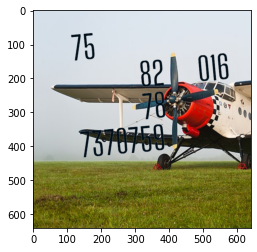

In [6]:
alphabet = string.digits
text_generator = my_numbers_generator(alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(80, 100),        
        # parametrs for text placement
        margin=50,
        # rotation around horizontal axis
        rotationX=(-0.001, 0.001),
        # rotation around vertical axis
        rotationY=(-0.01, 0.01),
        # rotation in the plane of image
        rotationZ=(-10, 10) 
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [7]:
detector = keras_ocr.detection.Detector()
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=alphabet,
    weights='kurapan'
)
recognizer.compile()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


This image contains: 2


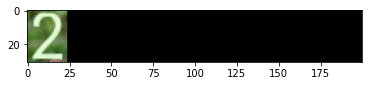

In [8]:
max_length = 41
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=1000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=35),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)

Once training is done, you can use `recognize` to extract text.

1/1 [==============================] - 0s 52ms/step
Predicted: ['61', '4081', '811', '800', '85', '40', '1008', '61', '1068', '0006', '29', '70', '220', '421']


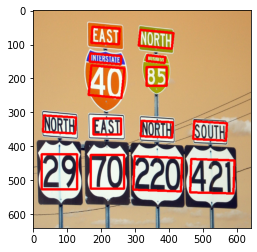

In [17]:
import cv2
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
#image, lines = next(image_generators[0]) #recognize generated images

# Load the image
image = cv2.imread('image.jpg')
# Resize the image
image = cv2.resize(image, (640, 640))
predictions = pipeline.recognize(images=[image])[0]

# Get the recognized text and bounding boxes from the prediction
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
#     'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
     'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)